In [1]:
import os
import cv2
import glob
from tqdm import tqdm

In [2]:
input_dir = "./Firefighting Device Detection.v6i.yolov11/train/images"
input_label = "./Firefighting Device Detection.v6i.yolov11/train/labels"
output_dir = "./dataset_crops"

In [27]:
def crop_and_save_symbols():
    os.makedirs(output_dir, exist_ok = True)
    # load path
    label_files = glob.glob(os.path.join(input_label, "*.txt"))

    crop_count = 0
    print(f"Found {len(label_files)} label files. Starting extraction...")

    for label_path in tqdm(label_files):
        base_name = os.path.basename(label_path).replace(".txt", "")
        img_path = os.path.join(input_dir, base_name + ".jpg")
    
        # load images
        image = cv2.imread(img_path)
        
        h_img, w_img, _ = image.shape

        # read annotations (YOLO11 format)
        with open(label_path, 'r') as f:
                lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            cls_id = parts[0]

            x_c, y_c, w_norm, h_norm = map(float, parts[1:])

            w_px = int(w_norm * w_img)
            h_px = int(h_norm * h_img)
            x_px = int((x_c * w_img) - (w_px // 2))
            y_px = int((y_c * h_img) - (h_px //2))

            # clamp to the image boundaries
            x_px = max(0, x_px)
            y_px = max(0, y_px)
            w_px = min(w_px, w_img - x_px)
            h_px = min(h_px, h_img - y_px)

            # crop_and_save_symbols
            crop = image[y_px:y_px+h_px, x_px:x_px + w_px]

            save_name = os.path.join(output_dir, f"symbol_{crop_count}.jpg")
            cv2.imwrite(save_name, crop)
            crop_count += 1
            
    print("cropping is done!!!")

In [28]:
crop_and_save_symbols()

Found 102 label files. Starting extraction...


100%|██████████| 102/102 [00:02<00:00, 41.15it/s]

cropping is done!!!


## train Simclr

In [3]:
import torch

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 128    # Needs to be large for Contrastive Learning
EPOCHS = 1000
LR = 3e-4
TEMP = 0.07         # Temperature parameter for NCE loss
EMBED_DIM = 128
DATA_DIR = "./dataset_crops"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device}")
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(0)}") # Prints name of the first GPU

Using device: cuda
Number of available GPUs: 3
Current GPU device name: NVIDIA RTX A6000


Starting training on cuda with 2606 symbols...
Epoch [1/200] Loss: 4.8320
Epoch [2/200] Loss: 4.4206
Epoch [3/200] Loss: 4.1692
Epoch [4/200] Loss: 3.8943
Epoch [5/200] Loss: 3.7196
Epoch [6/200] Loss: 3.6006
Epoch [7/200] Loss: 3.5529
Epoch [8/200] Loss: 3.4788
Epoch [9/200] Loss: 3.4518
Epoch [10/200] Loss: 3.4398
Saved Backbone Checkpoint at epoch 10
Epoch [11/200] Loss: 3.3460
Epoch [12/200] Loss: 3.2232
Epoch [13/200] Loss: 3.2048
Epoch [14/200] Loss: 3.1656
Epoch [15/200] Loss: 3.1388
Epoch [16/200] Loss: 3.1336
Epoch [17/200] Loss: 3.0739
Epoch [18/200] Loss: 3.0628
Epoch [19/200] Loss: 3.0336
Epoch [20/200] Loss: 2.9989
Saved Backbone Checkpoint at epoch 20
Epoch [21/200] Loss: 2.9831
Epoch [22/200] Loss: 2.9995
Epoch [23/200] Loss: 2.9303
Epoch [24/200] Loss: 2.9135
Epoch [25/200] Loss: 2.8846
Epoch [26/200] Loss: 2.8592
Epoch [27/200] Loss: 2.8983
Epoch [28/200] Loss: 2.8701
Epoch [29/200] Loss: 2.7976
Epoch [30/200] Loss: 2.8363
Saved Backbone Checkpoint at epoch 30
Epoch [3

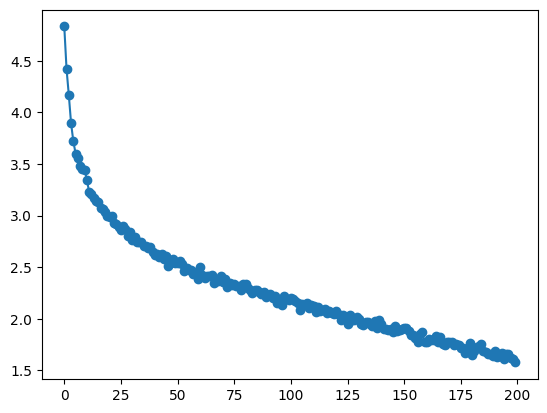

In [23]:
class SimCLRTransform:
    def __init__(self, size = 64):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=64, scale = (0.5, 1.0)),
            transforms.RandomRotation(180, expand=False),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p = 0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor()
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

class SymbolDataset(Dataset):
    def __init__(self, root_dir):
        self.files = glob.glob(os.path.join(root_dir, "*.jpg"))
        self.transform = SimCLRTransform()
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idk):
        img_path = self.files[idk]
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

class SimCLR(nn.Module):
    def __init__(self, base_model = "resnet18"):
        super().__init__()
        self.backbone = models.resnet18(weights=None)

        dim_mlp = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # add the projection head (MLP)
        # this is thrown away from training
        self.projection_head = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            nn.Linear(dim_mlp, EMBED_DIM)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection_head(features)
        return embeddings
    
    @staticmethod
    # define NT-Xent (Normalized Temperature-Scaled Cross-Entropy)
    def nt_xent_loss(z_i, z_j, temperature):
        batch_size = z_i.shape[0]

        features = torch.cat([z_i, z_j], dim = 0)

        features = torch.nn.functional.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T)

        # create labels
        labels = torch.cat([
            torch.arange(batch_size) + batch_size,
            torch.arange(batch_size)
        ], dim = 0).to(DEVICE)

        # mask out self-similarity by setting a very large value on the diagonal
        mask = torch.eye(2 * batch_size).to(DEVICE).bool()

        logits = similarity_matrix / temperature
        logits = logits.masked_fill(mask, -9e15)

        loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss

def train():
    dataset = SymbolDataset(DATA_DIR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE , shuffle=True, drop_last=True, num_workers=0)

    model = SimCLR().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr = LR)
    plot_loss = []
    print(f"Starting training on {DEVICE} with {len(dataset)} symbols...")

    for epoch in range(EPOCHS):
        total_loss = 0
        running_loss = 0.0
        for i, (img_view_1, img_view_2) in enumerate(dataloader):
            img_view_1 = img_view_1.to(DEVICE)
            img_view_2 = img_view_2.to(DEVICE)

            optimizer.zero_grad()

            # forward
            z1 = model(img_view_1)
            z2 = model(img_view_2)

            loss = model.nt_xent_loss(z1, z2, TEMP)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            # running_loss += loss.item()
            # if (i + 1) % 100 == 0:
            #     avg_running_loss = running_loss / 100
            #     print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i+1}/{len(dataloader)}] "
            #           f"Loss: {avg_running_loss:.4f}")
            #     running_loss = 0.0
        
        avg_loss = total_loss / len(dataloader)
        plot_loss.append(avg_loss)
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}")

        if (epoch+1) % 10 == 0:
            torch.save(model.backbone.state_dict(), f"simclr_backbone_epoch_{epoch+1}.pth")
            print(f"Saved Backbone Checkpoint at epoch {epoch+1}")
    np.save('loss.npy', np.array(plot_loss))
    print("List saved to loss.npy")

    plt.plot(plot_loss, marker='o', linestyle='-')
    plt.savefig('plot_loss.png')
    print("Plot saved to plot_output.png")

if __name__ == "__main__":
    train()


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from pdf2image import convert_from_path

## Convert pdf to high-quality image

In [13]:
image = convert_from_path("./test/landscaping-drawing.pdf", dpi = 300)
image[0].save("./test/drawing.png", "PNG")

c:\Users\m6moraxu\AppData\Local\anaconda3\envs\dgtwinV2\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (155520000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [26]:
MODEL_PATH = "./simclr_backbone_epoch_200.pth" # The file you just trained
DRAWING_PATH = "./test/drawing.png"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device}")
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(0)}")

WINDOW_SIZE = 600
MODEL_INPUT_SIZE = 64
STRIDE = 150
MATCH_THRESHOLD = 0.98
BATCH_SIZE = 1024

def load_backbone(path):
    backbone = models.resnet18(weights=None)
    backbone.fc = nn.Identity()

    state_dict = torch.load(path, map_location = DEVICE)
    backbone.load_state_dict(state_dict)

    backbone.to(DEVICE)
    backbone.eval()
    return backbone

def preprocess_batch(crop_list):
    batch_up = np.stack(crop_list)
    batch_tensor = torch.from_numpy(batch_up).to(DEVICE)
    batch_tensor = batch_tensor.permute(0,3,1,2)

    batch_tensor = batch_tensor.float() / 255.0

    return batch_tensor

    

def find_symbols():
    
    print("loading model...")
    model = load_backbone(MODEL_PATH)

    print(f"loading drawing: {DRAWING_PATH}")
    full_image = cv2.imread(DRAWING_PATH)
    if full_image is None:
        print("Error: loading image")
        return

    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB) 
    H, W, _ = full_image.shape
    print(f"Image Size: {W}x{H}")

    # --- define QUERY (the "1-shot") ---
    # ideally, the user'd use a mouse click. Here, I mimic by hardcoding a crop location
    qx, qy = 7030, 4780
    query_crop_huge = full_image[qy:qy+WINDOW_SIZE, qx:qx+WINDOW_SIZE]
    query_crop_small = cv2.resize(query_crop_huge, (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE))

    with torch.no_grad():
        q_tensor = preprocess_batch([query_crop_small])
        query_emb = model(q_tensor) # Shape: (1, 512)
    

    print("batch scanning document (this may take a while)...")

    results = []
    batch_crops = []
    batch_coords = []
    

    for y in range(0, H - WINDOW_SIZE, STRIDE):
        for x in range(0, W - WINDOW_SIZE, STRIDE):

            crop_huge = full_image[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]

            # skip areas where the crop is almost white
            if crop_huge.mean() > 240:
                continue
            
            crop_small = cv2.resize(crop_huge, (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE))
            batch_crops.append(crop_small)
            batch_coords.append((x,y))

            if len(batch_crops) == BATCH_SIZE:
                with torch.no_grad():
                    batch_tensor = preprocess_batch(batch_crops)

                    batch_embs = model(batch_tensor)

                    # output: (1, batch_size)
                    scores = torch.nn.functional.cosine_similarity(query_emb, batch_embs)
                    mask = scores > MATCH_THRESHOLD

                    indices = torch.nonzero(mask).squeeze()

                    if indices.numel() > 0:
                        # handle the case when "torch.nonzero(mask)"
                        # returns a single element, then squeeze() will
                        # give you a scalar wrapped in a scalar box, shape is [] 
                        if indices.dim() == 0: indices = indices.unsqueeze(0)
                        
                        # accumulate results per batch
                        for idx in indices:
                            idx = idx.item()
                            score = scores[idx].item()
                            match_x, match_y = batch_coords[idx]
                            results.append((match_x, match_y, score))
                # Reset Buffer
                batch_crops = []
                batch_coords = []

    # process leftovers
    if len(batch_crops) > 0:
        with torch.no_grad():
            batch_tensor = preprocess_batch(batch_crops)
            batch_embs = model(batch_tensor)
            scores = torch.nn.functional.cosine_similarity(query_emb, batch_embs)
            mask = scores > MATCH_THRESHOLD
            indices = torch.nonzero(mask).squeeze()
            if indices.numel() > 0:
                if indices.dim() == 0: indices = indices.unsqueeze(0)
                for idx in indices:
                    idx = idx.item()
                    score = scores[idx].item()
                    match_x, match_y = batch_coords[idx]
                    results.append((match_x, match_y, score))
    
    print(f"Done! Found {len(results)} matches.")

    # ---visualize---
    # Convert back to BGR for OpenCV saving
    output_img = cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR)
    
    # query box (blue)
    cv2.rectangle(output_img, (qx, qy), (qx+WINDOW_SIZE, qy+WINDOW_SIZE), (255, 0,0), 3)

    # potential matches (green)
    for (mx, my, score) in results:
        cv2.rectangle(output_img, (mx, my), (mx+WINDOW_SIZE, my+WINDOW_SIZE), (0, 255, 0), 2)

    # save results
    cv2.imwrite("./test/results.jpg", output_img)
    print("saved results to results.jpg") 

if __name__ == "__main__":
    find_symbols()

Using device: cuda
Number of available GPUs: 3
Current GPU device name: NVIDIA RTX A6000
loading model...
loading drawing: ./test/drawing.png
Image Size: 14400x10800
batch scanning document (this may take a while)...
Done! Found 214 matches.
saved results to results.jpg
